In [ ]:
#same auto segment code as before, but we are using bounding box as a prompt
#we are getting more accurate masks with the Bounding Box prompt in fine tuned model than the automatic mask generator

import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!nvidia-smi

Mon Apr 14 02:44:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Install dependencies if you haven't already
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/content/segment-anything-2
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 76, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
!pip install -q supervision jupyter_bbox_widget

^C


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

^C


In [ ]:
import os

os.rename("/content/wing_segment-1", "/content/data")

In [ ]:
%cd {HOME}/segment-anything-2
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

/content/segment-anything-2


In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:
#loading fine tuned SAM model
#save the config file in /content/segment-anything-2/sam2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/checkpoint.pt"
CONFIG = "sam2.1_hiera_b+ (1).yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [ ]:
#To load Base SAM

checkpoint_base = f"{HOME}/checkpoints/sam2_hiera_large.pt"
model_cfg_base = "sam2_hiera_l.yaml"
sam2_base = build_sam2(model_cfg_base, checkpoint_base, device="cuda")
mask_generator_base = SAM2AutomaticMaskGenerator(sam2_base)

In [ ]:
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
#only for 1 image
IMAGE_PATH = f"/content/data/test/P1310282_JPG_jpg.rf.d5bf792f699c7e6f296e99863762202c.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

    #Bounding box
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

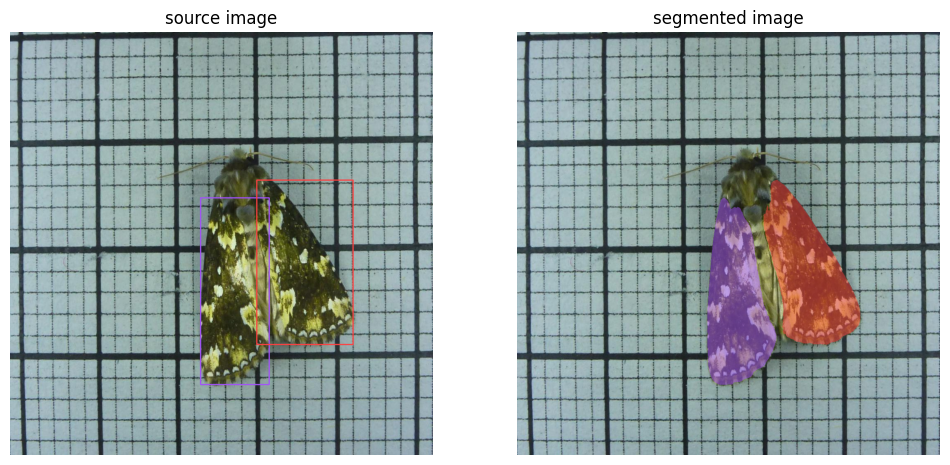

In [ ]:
#getting dimensions of bb
widget.bboxes

#enter the dimensions of bb

default_box = [{'x': 254, 'y': 405, 'width': 301, 'height': 206, 'label': ''},
 {'x': 595, 'y': 412, 'width': 243, 'height': 255, 'label': ''}]



boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

# predictor

predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# With one box as input, predictor returns masks of shape (1, H, W);
# with N boxes, it returns (N, 1, H, W).
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)

#plot

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

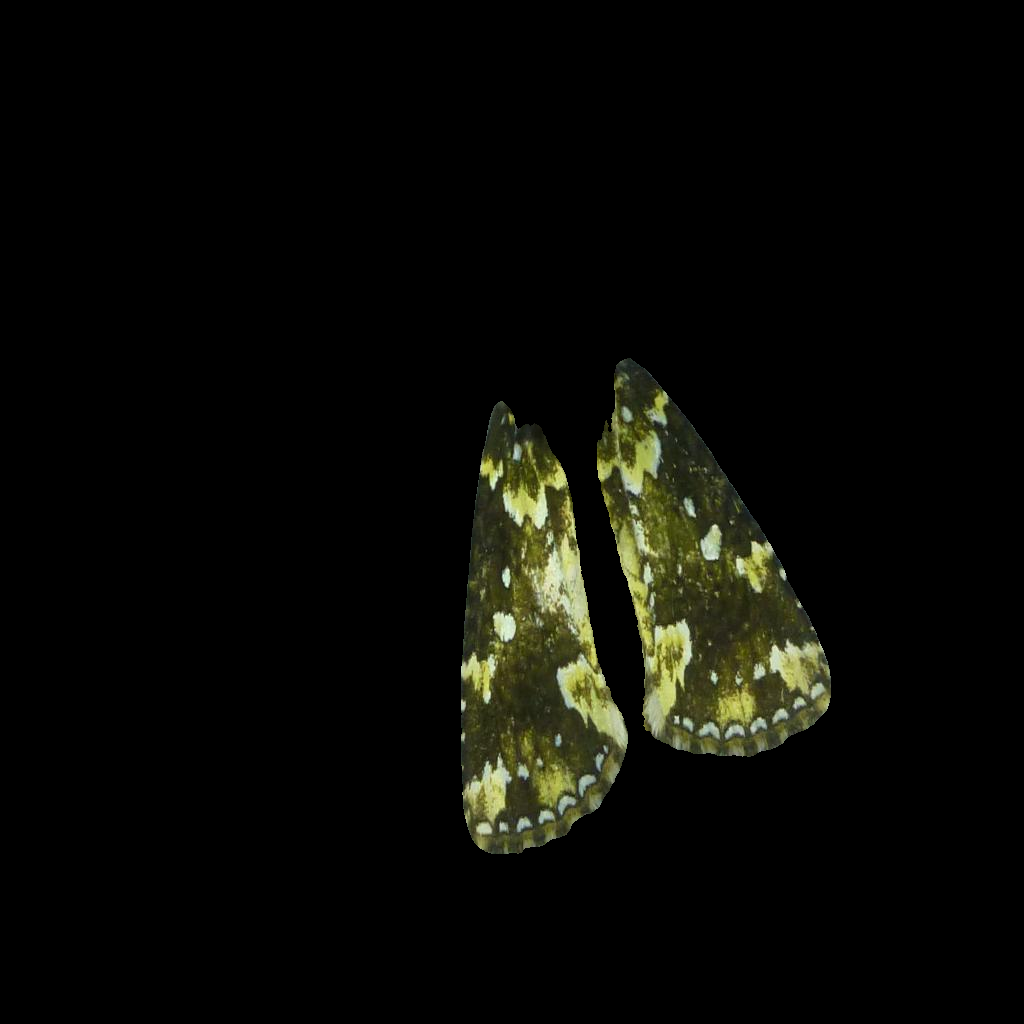

In [ ]:
# Function to segment out the predicted image part in a segmented image.
# Assuming 'masks' contains the predicted masks and 'image_bgr' is the original image.

import cv2
import numpy as np

def segment_out_predicted_image_part(masks, image_bgr):
    """Segments out the predicted image part in a segmented image.

    Args:
        masks: A NumPy array of shape (N, H, W) representing the predicted masks,
               where N is the number of masks, H is the image height, and W is the image width.
        image_bgr: A NumPy array of shape (H, W, 3) representing the original image in BGR format.

    Returns:
        A NumPy array of shape (H, W, 3) representing the segmented image.
    """

    # Ensure masks is a NumPy array.
    masks = np.array(masks)

    # Get the dimensions of the image and masks
    height, width = image_bgr.shape[:2]

    # Create a blank image of the same size as the original image.
    segmented_image = np.zeros_like(image_bgr)

    # Iterate through each predicted mask.
    for mask in masks:
        # Find the coordinates of the non-zero pixels (the predicted segment).
        coords = np.argwhere(mask)

        # Use the coordinates to extract the corresponding pixels from the original image.
        for y, x in coords:
            segmented_image[y, x] = image_bgr[y, x]

    return segmented_image

# Example usage (assuming you have masks and image_bgr from the previous code):
segmented_image_output = segment_out_predicted_image_part(masks, image_bgr)
cv2.imwrite("segmented_part.jpg", segmented_image_output)


# To display the image in colab
from google.colab.patches import cv2_imshow
cv2_imshow(segmented_image_output)


In [ ]:
#plot and save binary masks of segmented masks merged into one image
%cd {HOME}
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Assuming 'masks' contains the predicted masks and 'IMAGE_PATH' is defined.

# Create a blank image with the same dimensions as the first mask
merged_mask = np.zeros_like(masks[0], dtype=np.uint8)

# Iterate through each mask and add it to the merged mask
for i, mask in enumerate(masks):
    # Convert the boolean mask to an image (0 or 255) and add to merged_mask
    mask_image = (mask * 255).astype(np.uint8)
    merged_mask = cv2.add(merged_mask, mask_image)  # Use cv2.add to avoid overflow

# Clip the merged mask to ensure pixel values are within 0-255
merged_mask = np.clip(merged_mask, 0, 255).astype(np.uint8)

# Get the original image filename and modify it for the mask
image_filename = os.path.basename(IMAGE_PATH)  # Extract filename from IMAGE_PATH
  # Add "_mask" before extension

# Save the merged mask with the modified filename
plt.imsave(image_filename, merged_mask, cmap='gray')

/content
